In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
# connect to nested folder structure:
# Dataset_BUSI_with_GT -> train -> benign
#                                  malignant
#                                  normal
#                         test  -> benign
#                                  malignant
#                                  normal

# connect to path where the data is
downloads_path = os.path.expanduser("~/Downloads")
dataset_path = os.path.join(downloads_path, "Dataset_BUSI_with_GT")

# set image size
# original sizes all over the place, using 112x112 for efficiency without getting rid of too much information
img_size = (112, 112)

# class labels, asking "does this MRI contain a benign tumor or no tumor?" another way of determining if someone has cancer or not
class_labels = {'benign': 1, 'normal': 0}

# load in training data
train_labels = []
train_images = []

train_path = os.path.join(dataset_path, 'train')

for class_name in ['benign', 'normal']:
    class_path = os.path.join(train_path, class_name)
    
    for img_file in os.listdir(class_path):
        if img_file.lower().endswith(('.png')):
            img_path = os.path.join(class_path, img_file)
            
            img = Image.open(img_path).convert('L') 
            img = img.resize(img_size)
            img_array = np.array(img)
            img_array = np.expand_dims(img_array, axis=-1)
            
            train_images.append(img_array)
            train_labels.append(class_labels[class_name])

# load in test data
test_labels = []
test_images = []

# connects to the test folder within the Dataset_BUSI_with_GT folder
test_path = os.path.join(dataset_path, 'test')

# grab images in benign and normal folders
for class_name in ['benign', 'normal']:
    class_path = os.path.join(test_path, class_name)
    
    for img_file in os.listdir(class_path):
        if img_file.lower().endswith(('.png')):
            img_path = os.path.join(class_path, img_file)

            # convert to grayscale
            img = Image.open(img_path).convert('L') 

            # resize images to 224x224
            img = img.resize(img_size)
            img_array = np.array(img)
            
            # add channel dimension
            img_array = np.expand_dims(img_array, axis=-1) 
            
            test_images.append(img_array)
            test_labels.append(class_labels[class_name])

# convert to numpy arrays and standardize
x_train = np.array(train_images, dtype='float32') / 255.0
y_train = np.array(train_labels, dtype='float32')

x_test = np.array(test_images, dtype='float32') / 255.0
y_test = np.array(test_labels, dtype='float32')

# print shapes for future use if there are bugs in CNN
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"\nBenign (1): {np.sum(y_train == 1)} train, {np.sum(y_test == 1)} test")
print(f"Normal (0): {np.sum(y_train == 0)} train, {np.sum(y_test == 0)} test")

x_train shape: (462, 112, 112, 1)
y_train shape: (462,)
x_test shape: (108, 112, 112, 1)
y_test shape: (108,)

Benign (1): 353 train, 84 test
Normal (0): 109 train, 24 test


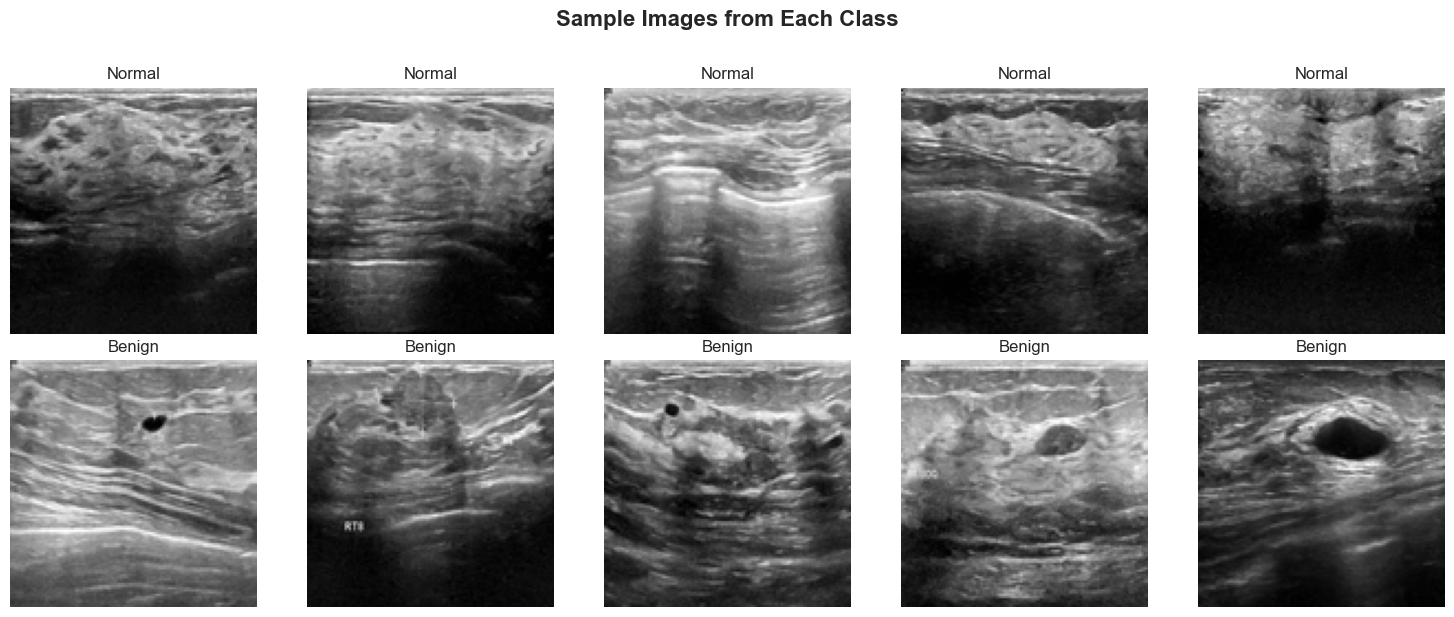

In [6]:
# look at images from both classes
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# show 5 normal images
normal_indices = np.where(y_train == 0)[0]
for i in range(5):
    idx = normal_indices[i]
    axes[0, i].imshow(x_train[idx].squeeze(), cmap='gray')
    axes[0, i].set_title('Normal', fontsize=12)
    axes[0, i].axis('off')

# show 5 benign images
benign_indices = np.where(y_train == 1)[0]
for i in range(5):
    idx = benign_indices[i]
    axes[1, i].imshow(x_train[idx].squeeze(), cmap='gray')
    axes[1, i].set_title('Benign', fontsize=12)
    axes[1, i].axis('off')

plt.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

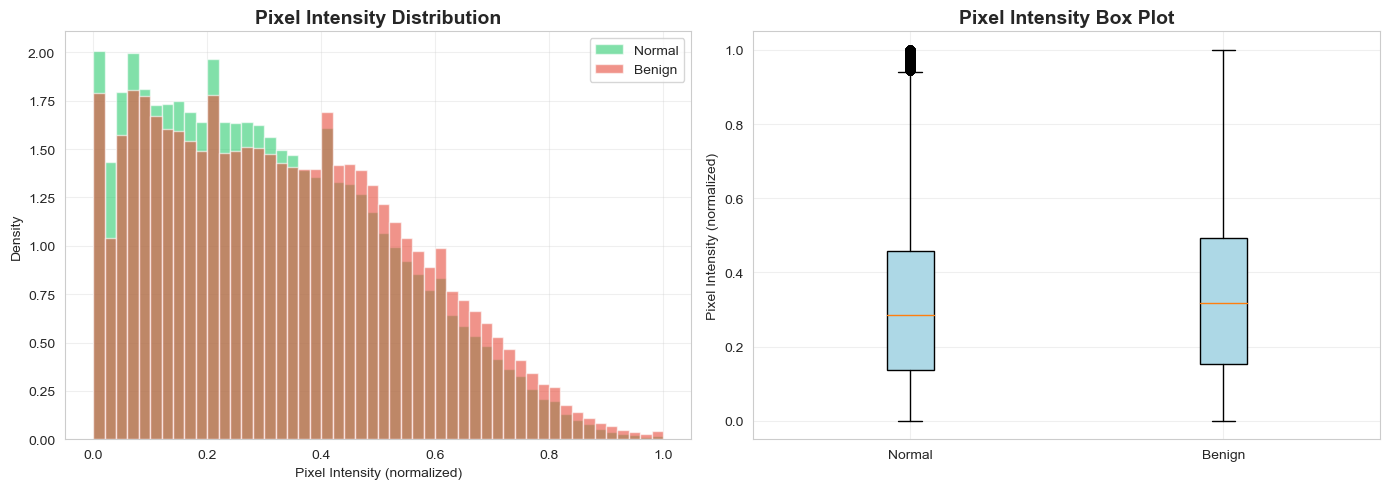

In [7]:
# pixel intensity distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# pixel values for each class
normal_pixels = x_train[y_train == 0].flatten()
benign_pixels = x_train[y_train == 1].flatten()

# histogram
axes[0].hist(normal_pixels, bins=50, alpha=0.6, label='Normal', color='#2ecc71', density=True)
axes[0].hist(benign_pixels, bins=50, alpha=0.6, label='Benign', color='#e74c3c', density=True)
axes[0].set_title('Pixel Intensity Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Pixel Intensity (normalized)')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
data_to_plot = [normal_pixels, benign_pixels]
axes[1].boxplot(data_to_plot, labels=['Normal', 'Benign'], 
                patch_artist=True,
                boxprops=dict(facecolor='lightblue'))
axes[1].set_title('Pixel Intensity Box Plot', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Pixel Intensity (normalized)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


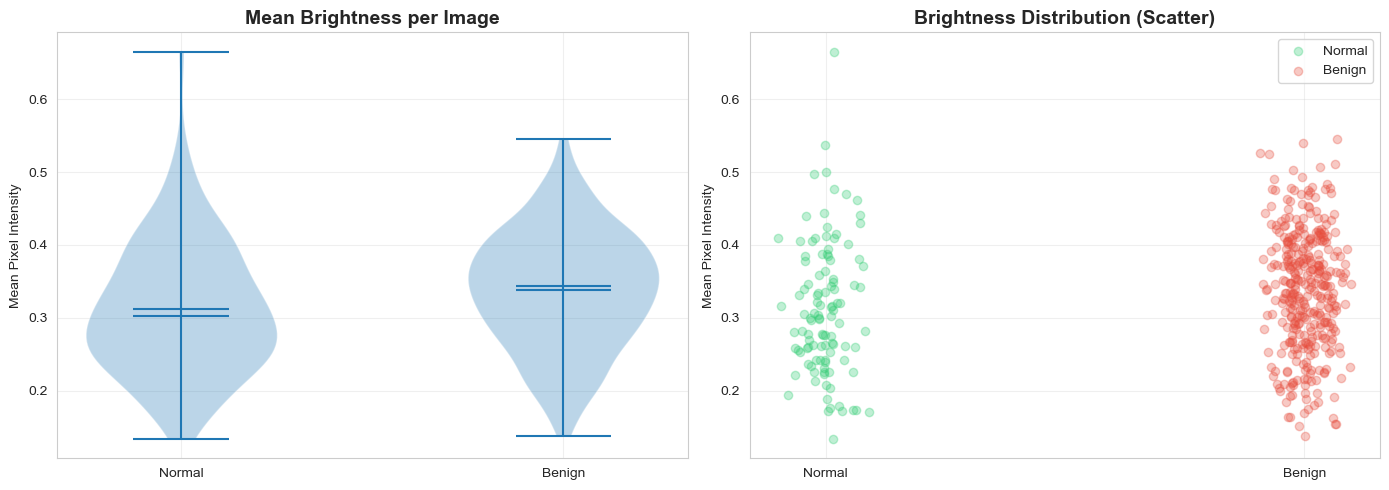

In [9]:
# ============================================================================
# 5. BRIGHTNESS STATISTICS
# ============================================================================

# Calculate mean brightness for each image
normal_brightness = [np.mean(x_train[i]) for i in range(len(x_train)) if y_train[i] == 0]
benign_brightness = [np.mean(x_train[i]) for i in range(len(x_train)) if y_train[i] == 1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Violin plot
parts = axes[0].violinplot([normal_brightness, benign_brightness], 
                           positions=[0, 1],
                           showmeans=True, showmedians=True)
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Normal', 'Benign'])
axes[0].set_title('Mean Brightness per Image', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Mean Pixel Intensity')
axes[0].grid(alpha=0.3)

# Scatter plot with jitter
normal_x = np.random.normal(0, 0.04, size=len(normal_brightness))
benign_x = np.random.normal(1, 0.04, size=len(benign_brightness))

axes[1].scatter(normal_x, normal_brightness, alpha=0.3, color='#2ecc71', label='Normal')
axes[1].scatter(benign_x, benign_brightness, alpha=0.3, color='#e74c3c', label='Benign')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Normal', 'Benign'])
axes[1].set_title('Brightness Distribution (Scatter)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Mean Pixel Intensity')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()
